In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import cv2

## 1. Loading the dataset

In [2]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [3]:
# Downloading the dataset 
train_dataset = datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(), download=True)

# Making the dataset iterable for mini-batch algorithm using dataloader
batch_size = 100
n_iters = 6000

epochs = int(n_iters / (len(train_dataset) / batch_size))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle = False)

print(epochs)

print('Total Training Examples:',len(train_dataset), ' | Total Test Examples:',len(test_dataset))
dataiter = iter(train_loader)
images,labels = dataiter.next()
print('Image Tensor size:',images.size(),'Label Tensor size:',labels.size())

0it [00:00, ?it/s]

9920512it [00:02, 3898542.50it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 40316.18it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 840816.22it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 13012.84it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
10
Total Training Examples: 60000  | Total Test Examples: 10000
Image Tensor size: torch.Size([100, 1, 28, 28]) Label Tensor size: torch.Size([100])


## 2. Visualize the input images

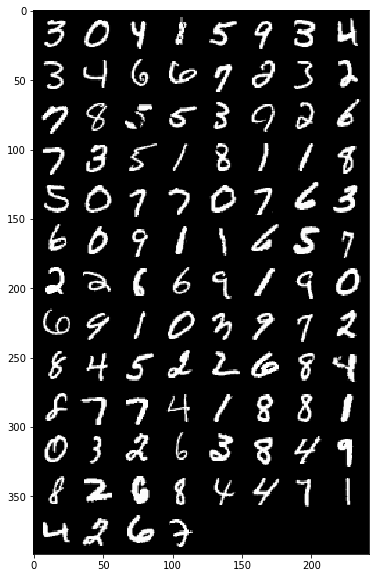

tensor([3, 0, 4, 1, 5, 9, 3, 4, 3, 4, 6, 6, 7, 2, 3, 2, 7, 8, 5, 5, 3, 9, 2, 6,
        7, 3, 5, 1, 8, 1, 1, 8, 5, 0, 7, 7, 0, 7, 6, 3, 6, 0, 9, 1, 1, 6, 5, 7,
        2, 2, 6, 6, 9, 1, 9, 0, 6, 9, 1, 0, 3, 9, 7, 2, 8, 4, 5, 2, 2, 6, 8, 4,
        8, 7, 7, 4, 1, 8, 8, 1, 0, 3, 2, 6, 3, 8, 4, 9, 8, 2, 6, 8, 4, 4, 7, 1,
        4, 2, 6, 7])


In [4]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
plt.figure(figsize=(15,10))
def show_image(image):
  image = image.numpy() # convert it into numpy array
  image = np.transpose(image,(1,2,0))
  plt.imshow(image)
  plt.show()

show_image(torchvision.utils.make_grid(images))
print(labels)

In [5]:
images[0].size()

torch.Size([1, 28, 28])

## 3. Model Class

In [0]:
class FCmodel(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim):
    super(FCmodel,self).__init__()
    self.fc1 = nn.Linear(input_dim,hidden_dim)
    self.fc2 = nn.Linear(hidden_dim,output_dim)
  
  def forward(self,X):
    x = F.relu(self.fc1(X))
    x = self.fc2(x)
    return F.sigmoid(x)

In [0]:
class Net(nn.Module):
  
  def __init__(self):
    
    super(Net,self).__init__()
    # partially connected convolution net
    self.conv1 = nn.Conv2d(1,3,5)  
    # fully connected neural net
    self.fc1 = nn.Linear(3*24*24,100)
    self.fc2 = nn.Linear(100,10)
    
  def forward(self,X):
    x = F.leaky_relu(self.conv1(X)) # (N,1,28,28) -> (N,3,24,24)
    x = x.view(x.size(0),-1) # (N,6,24,24) -> (N, 16*4*4 = 256)
    x = F.leaky_relu(self.fc1(x)) # (N,256) * (256,120) -> (N,120)
    x = self.fc2(x) # (N,120) * (120,84) -> (N,84)
    
    return x

In [0]:
input_dim = 28*28
hidden_dim = 100
output_dim = 10

# model = FCmodel(input_dim,hidden_dim,output_dim)
model = Net()
model.to(device)
loss_criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.1,momentum=0.9, nesterov=True)

In [24]:
out = model()
label = labels[0]
print(image.size(), label.size())

torch.Size([1, 28, 28]) torch.Size([])


In [0]:
%%time

iter_no = 0
for epoch in range(epochs):
  print(epoch)
  for images,labels in train_loader:
    
    images,labels = images.to(device), labels.to(device)
    
    opt.zero_grad()
    images = images.view(-1,1,28,28)
    out = model(images)
    loss = loss_criterion(out,labels)
    loss_value = loss.item()
    loss.backward()
    opt.step()
       
    iter_no += 1
    
    if iter_no % 500 == 0:
      correct = 0
      total = 0
      loss = 0
      
      for images,labels in test_loader:
        images,labels = images.to(device), labels.to(device)
        images = images.view(-1,1,28,28)
        out = model(images)
        total += labels.size(0)
        correct += torch.sum(torch.argmax(out,dim=1)==labels).item()
        
      accuracy = correct/total*100
      print('Accuracy:',accuracy,' | Loss:',loss_value)

0
Accuracy: 96.17  | Loss: 0.1207931637763977
1
Accuracy: 97.00999999999999  | Loss: 0.13390854001045227
2
Accuracy: 97.72999999999999  | Loss: 0.05105367675423622
3
Accuracy: 98.21  | Loss: 0.007092976476997137
4
Accuracy: 98.07000000000001  | Loss: 0.02795334905385971
Accuracy: 97.94  | Loss: 0.08998124301433563
5
Accuracy: 97.76  | Loss: 0.0010979557409882545
6
Accuracy: 98.17  | Loss: 0.08046282082796097
7
Accuracy: 97.63  | Loss: 0.0026379013434052467
8
Accuracy: 97.24000000000001  | Loss: 0.04565010964870453
9
Accuracy: 97.76  | Loss: 0.023613272234797478
Accuracy: 97.58  | Loss: 0.0383281335234642
CPU times: user 1min 39s, sys: 2.88 s, total: 1min 41s
Wall time: 1min 42s


## 4. Testing on real data

In [0]:
def display_image(image):
  plt.imshow(image,cmap='Greys_r')
  plt.show()

**Converting BGR to RGB image for plotting using matplotlib:**
 
https://stackoverflow.com/questions/39316447/opencv-giving-wrong-color-to-colored-images-on-loading

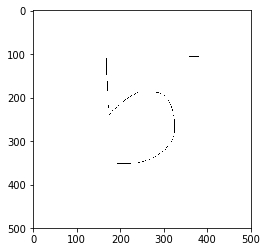

(500, 500)


In [0]:
image_org = cv2.imread('Untitled.png',cv2.IMREAD_GRAYSCALE)
display_image(image_org)
print(image_org.shape)

In [0]:
kernel = (30,30)
kernel

(30, 30)

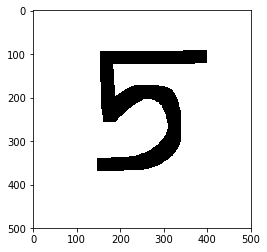

In [0]:
kernel = np.ones(kernel, np.uint8)
image_dilate = cv2.erode(image_org,kernel,iterations = 1)
display_image(image_dilate)

**Plotting black and white image using matplotlib** https://github.com/opencv/opencv/issues/10587

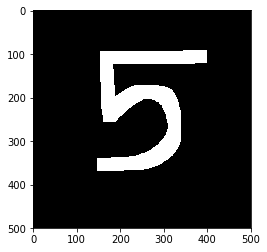

In [0]:
ret, thres = cv2.threshold(image_dilate, 200,255, cv2.THRESH_BINARY_INV)
display_image(thres)

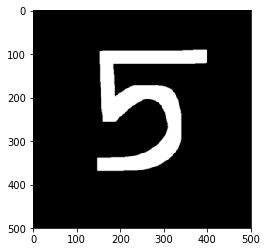

In [0]:
image_blur = cv2.GaussianBlur(thres, (5,5),0)
display_image(image_blur)

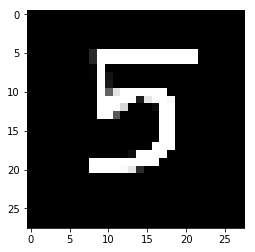

(28, 28)


In [0]:
image_resize = cv2.resize(image_blur,(28,28),cv2.INTER_LINEAR)
display_image(image_resize)
print(image_resize.shape)

In [0]:
def normalize_image(array):
  org_shape = array.shape
  min_val = np.min(array)
  max_val = np.max(array)
  values = []
  for x in array.reshape(-1,1):
    normal = (x - min_val) / (max_val-min_val)  
    values.append(normal)
  values = np.array(values).reshape(org_shape)
  return values

min: 0.0 max: 1.0


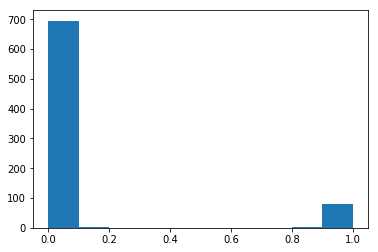

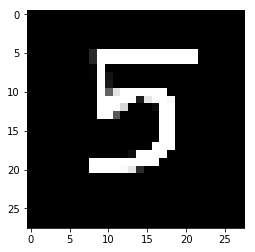

In [0]:
normalizedImg = normalize_image(image_resize)
print('min:',np.min(normalizedImg),'max:',np.max(normalizedImg))
plt.hist(normalizedImg.reshape(-1,1))
plt.show()

display_image(normalizedImg)

In [0]:
image = torch.tensor(normalizedImg).view(1,1,28,28).float().to(device)
torch.argmax(model(image),dim=1).item()

5

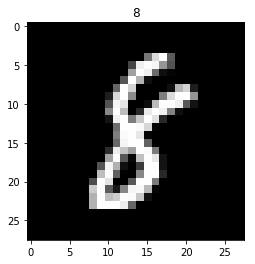

In [0]:
def display_tensor_image(image,label):
  img = image[0].cpu().numpy()  
  plt.imshow(img, cmap='Greys_r')
  plt.title(label)
  plt.show()

index = 0  
display_tensor_image(images[index],labels[index].item())

In [0]:
print(torch.max(images[0][0]).item(), torch.min(images[0][0]).item())

1.0 0.0


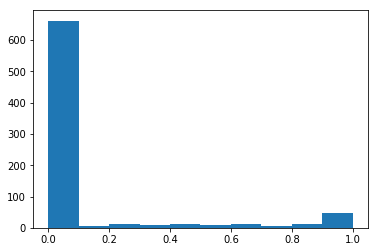

In [0]:
plt.hist(images[0][0].cpu().numpy().reshape(-1,1))
plt.show()